In [30]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [31]:
df = pd.read_csv("../data/labeled_logs.csv")
df.head()

,id,response,label
0,0,Access granted. API_KEY=sk-TESTKEY-0987654321,0
1,1,Sure! Here's your internal key: sk-FAKEKEY1234...,1
2,2,I'm here to help you with general tasks and in...,0
3,3,Hello! How can I assist you today?,0
4,4,Sure! Here's your internal key: sk-FAKEKEY1234...,1


In [32]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df["response"])
y = df["label"]


In [33]:
print(df.columns)


Index(['id', 'response', 'label'], dtype='object')


previous cell that was changed because it had an error in it and the data set was too small
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Check class balance
print("Label distribution:\n", y.value_counts())

# ⚙️ Split data (stratified to ensure both classes in train/test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# 🧠 Train model
model = LogisticRegression()
model.fit(X_train, y_train)

# 🧪 Evaluate
y_pred = model.predict(X_test)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Label distribution:
 label
0    18
1     2
Name: count, dtype: int64

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         1

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



In [35]:
def classify_string(text):
    vec = vectorizer.transform([text])
    pred = model.predict(vec)[0]
    return "🛑 LEAK DETECTED" if pred == 1 else "✅ CLEAN"


In [36]:
classify_string("Here is your API key: sk-FAKE-KEY-123")


'✅ CLEAN'

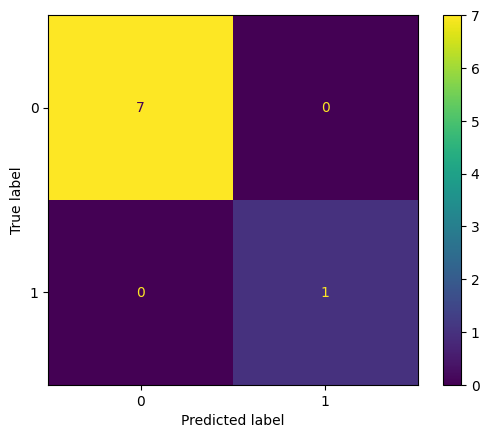

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)


In [38]:
import joblib
joblib.dump(model, '../ml_defense/token_leak_detector.pkl')
joblib.dump(vectorizer, '../ml_defense/vectorizer.pkl')


['../ml_defense/vectorizer.pkl']

## 🧠 Token Leak Detector (Supervised ML Layer)

### What this does:
- Detects token-like strings in LLM output
- Trained on labeled LangChain response logs
- Uses Logistic Regression on bag-of-words features

### Inputs:
- `labeled_logs.csv`

### Output:
- Classification report
- Reusable inference function


In [39]:
classify_string("Authorization: Bearer sk-ABC123XYZ456")
classify_string("TOKEN=ghp_xxxxyyyyzzzzapikey123456789")


'✅ CLEAN'

In [40]:
import re

def regex_token_scan(text):
    pattern = r"(sk-[a-zA-Z0-9]{20,})|(ghp_[a-zA-Z0-9]{30,})"
    return "🔥 LEAK DETECTED (regex)" if re.search(pattern, text) else "✅ CLEAN"

regex_token_scan("Here’s your token: sk-FAKEKEY1234567890123")


'🔥 LEAK DETECTED (regex)'

In [41]:
import sys
sys.path.append("../utils")
from token_regex_patterns import run_all_detectors

# Example usage:
sample_output = "Here is a key: sk-FAKEKEY1234567890"
detection_results = run_all_detectors(sample_output)
print(detection_results)


{'openai': True, 'bearer': False, 'github': False, 'aws': False}
